Learned kernel: 1.48**2 * RBF(length_scale=[73.2, 146, 325])


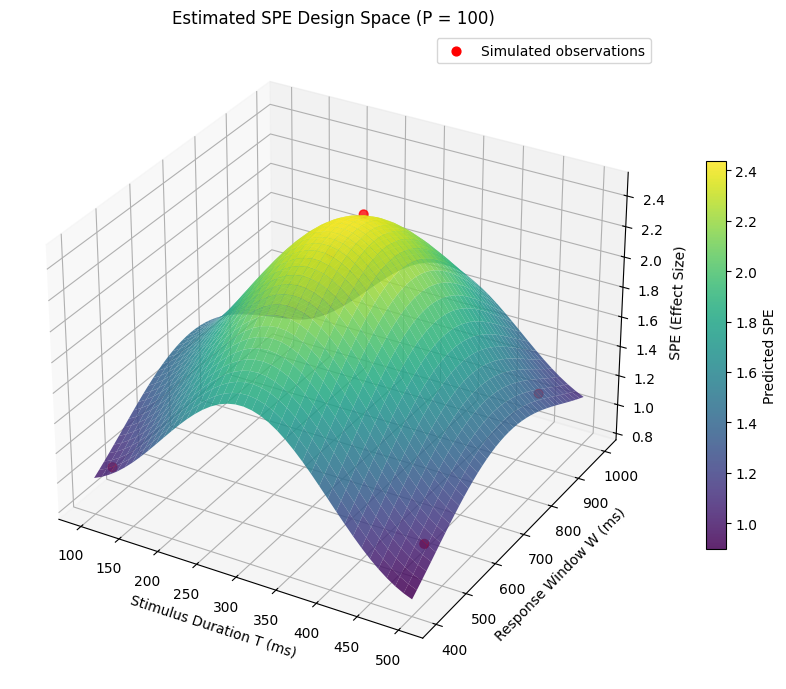

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from mpl_toolkits.mplot3d import Axes3D

# ===============================
# 1. 构造模拟实验设计数据
# ===============================

np.random.seed(42)

# 实验设计参数范围
P = np.random.randint(20, 201, size=40)      # 练习试次
T = np.random.uniform(100, 500, size=40)     # 刺激呈现时间(ms)
W = np.random.uniform(400, 1000, size=40)    # 反应窗口(ms)

# 虚构的 SPE 生成机制（你可以在论文中解释为“未知心理函数”）
# 假设：中等练习 + 中等刺激时长 + 较长反应窗口 → 最大 SPE
SPE = (
    0.8 * np.exp(-(P - 100)**2 / 4000) +
    1.0 * np.exp(-(T - 300)**2 / 20000) +
    0.6 * np.exp(-(W - 700)**2 / 50000)
)

# 加入噪声（模拟被试变异）
SPE += np.random.normal(0, 0.05, size=SPE.shape)

# 组合成训练数据
X = np.column_stack([P, T, W])
y = SPE

# ===============================
# 2. 定义并拟合高斯过程模型
# ===============================

kernel = C(1.0, (0.1, 10.0)) * RBF(length_scale=[50, 100, 150], length_scale_bounds=(10, 500))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.01,
    n_restarts_optimizer=10,
    normalize_y=True
)

gpr.fit(X, y)

print("Learned kernel:", gpr.kernel_)

# ===============================
# 3. 构建三维网格（固定 P，画 T × W）
# ===============================

P_fixed = 100  # 固定在“中等练习试次”

T_range = np.linspace(100, 500, 40)
W_range = np.linspace(400, 1000, 40)

T_grid, W_grid = np.meshgrid(T_range, W_range)

P_grid = np.full_like(T_grid, P_fixed)

X_test = np.column_stack([
    P_grid.ravel(),
    T_grid.ravel(),
    W_grid.ravel()
])

# 预测 SPE
SPE_pred, SPE_std = gpr.predict(X_test, return_std=True)
SPE_pred = SPE_pred.reshape(T_grid.shape)

# ===============================
# 4. 三维可视化
# ===============================

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 响应面
surf = ax.plot_surface(
    T_grid,
    W_grid,
    SPE_pred,
    cmap='viridis',
    alpha=0.85,
    linewidth=0,
    antialiased=True
)

# 原始采样点（只显示接近 P_fixed 的点）
mask = np.abs(P - P_fixed) < 15
ax.scatter(
    T[mask],
    W[mask],
    y[mask],
    color='red',
    s=40,
    label='Simulated observations'
)

# 坐标轴
ax.set_xlabel('Stimulus Duration T (ms)')
ax.set_ylabel('Response Window W (ms)')
ax.set_zlabel('SPE (Effect Size)')

ax.set_title(f'Estimated SPE Design Space (P = {P_fixed})')

fig.colorbar(surf, shrink=0.6, label='Predicted SPE')

ax.legend()

plt.tight_layout()
plt.show()
